# Movie Review Analysis

In this project, I will build a recurrent neural network to work with sequential text data, specificially, movie review data to identify the reviewer sentiment.

# PART A - Sentiment Analysis

In this part I will construct a world-level LSTM model for identifying positive and negative reviews.

In [ ]:
# load standard modules/libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# load special modules/libraries
import os
import warnings
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter
import string
import re
from tqdm  import tqdm

# load pytorch modules/libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part 1. Data Cleaning

I will be using the "IMDB Movie Review Dataset".

### Part (i)

Open up the file in Python, and examine some examples of positive and negative reviews. Comment on the quality of the data and any challenges I foresee in working with these data. Pick one example of a positive review and one of a negative review to support my comments.

In [ ]:
# download IMDB review data

# load dataset
df = pd.read_csv("IMDB Dataset.csv")

# process into data and labels
X = df['review'].values
y = df['sentiment'].values


In [ ]:
# check missing values
print('Missing values in review:', df['sentiment'].isna().sum())
print('Missing values in sentiment:',df['review'].isna().sum())

# check if data is balanced
df['sentiment'].value_counts()

Missing values in review: 0
Missing values in sentiment: 0


positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
# positive review
print('Review sentiment:', df['sentiment'][0])
df['review'][0]

Review sentiment: positive


"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
# negative review
print('Review sentiment:', df['sentiment'][7])
df['review'][7]

Review sentiment: negative


"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air."

The data quality is good because there is no missing value in reviews or
sentiment and it is a balanced dataset since there are equal number of positive
and negative reviews. The review text is also clean, which can be seen from the
reviews above.

One challenge is that length of movie review varies. For example, the positive
review above has much more length than the negative review above.
Another challenge is that some reviews may start by complimenting the movie but
the remaining paragraph was all criticism, which requires the model to
accurately identify these change of tone. For example, a bad model may classify
the negative review above as positive if it only looks at the first sentence
"This show was an amazing, fresh & innovative idea".

### Part (ii)

Perform summary statistics on the dataset.

In [ ]:
# summary statistics
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
# average character length of a review
print('Average length:', df['review'].apply(len).mean())
# longest length
print('Longest length:', df['review'].apply(len).max())
# shortest length
print('Shortest length:', df['review'].apply(len).min())

Average length: 1309.43102
Longest length: 13704
Shortest length: 32


In [ ]:
# number of positive and negative reviews
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Text(0, 0.5, 'Average length')

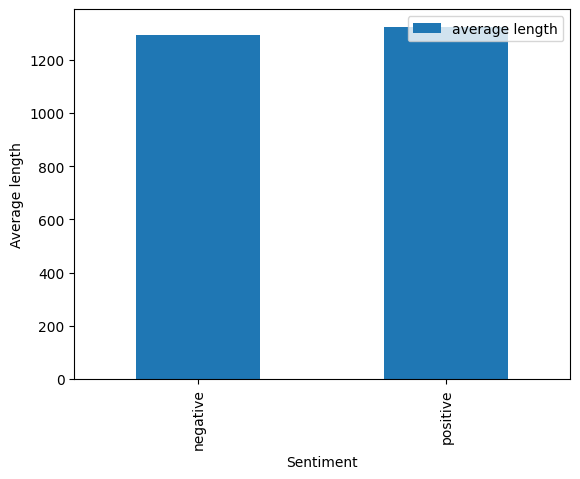

In [ ]:
# plot histogram
df['review length'] = df['review'].apply(len)
avg_length = df.groupby('sentiment')['review length'].mean()
df_avg = pd.DataFrame({'sentiment':avg_length.index,
                       'average length':avg_length.values})
df_avg.plot.bar(x = 'sentiment', y = 'average length')
plt.xlabel('Sentiment')
plt.ylabel('Average length')

In [ ]:
# see the actual number
df_avg

,sentiment,average length
0,negative,1294.06436
1,positive,1324.79768


General observations :
There are duplicate reviews and the most frequent review shows up five times.
The length of reviews vary greatly from shortest of 32 to longest of 13704.


Observations positive vs negative:
There are equal number of positive reviews and negative reviews, which means the
dataset is balanced.
But the average length of positive reviews is longer than the average length of
negative reviews. This could affect the model to learn predicting based on
length of reviews instead of actual meaning of text.

### Part (iii)

The following helper code will be used to process the data before we can train our LSTM model.

In [ ]:
X[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
def preprocess_string(str1):
    # remove all non-word characters excluding number and letters
    str1= re.sub(r"[^\w\s]",'',str1)
    # remove all whitespace with no space
    str1= re.sub(r"\s",'',str1)
    # replace digits with no space
    str1= re.sub(r"\d",'',str1)
    return str1

def preprocess_sentence(sen1):
    word_list=[]
    stop_word = set(stopwords.words("english"))
    for word in sen1.lower().split():
        word = preprocess_string(word)
        if word not in stop_word and word!='':
            word_list.append(word)
    return word_list

def get_stoi(data):
    word_list=[]
    for review in data:
        word_list.extend(preprocess_sentence(review))
    corpus = Counter(word_list)
    print(corpus.get)
    # sorting on the basis of most common words
    corpus_ =sorted(corpus,key= corpus.get,reverse=True)[:1000]
    # creating a dict
    stoi =  {ch:i+1 for i,ch in enumerate(corpus_)}
    return stoi

def tokenize(data, labels, stoi):
    # tokenize
    data_encoded = []
    for review in data:
        data_encoded.append([stoi[word] for word in preprocess_sentence(review)
                                     if word in stoi.keys()])

    labels_encoded = [1 if label =='positive' else 0 for label in labels]

    return np.array(data_encoded), np.array(labels_encoded)

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review)!=0:
            features[ii, -len(review):] = np.array(review)[:seq_len]

    return features

In [ ]:
set(stopwords.words("english"))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

Steps:
1. Preprocess review by lowercasing, splitting sentence into words,
preprocessing words, stop words removal
2. Preprocess words by removing non-word characters, whitespaces and digits
3. Create dictionary with top 1000 most common words
4. Tokenize review and encode using the created dictionary
5. Encode labels
6. Create padding for each sequence in sentences

These steps are necessary for training because they help clean, standardize and
create a meaningful representation of data, which helps LSTM learn effectively.
Step 1 helps standardize LSTM to treat different cases equally and make
embedding more meaningful by removing meaningless stop words.
Step 2 helps remove irrelavant characters and reduce noise.
Step 3 helps create dictionary to count word frequency as the feature of each
word in the global corpus.
Step 4 and 5 helps transform text data into numerical data since LSTM only work
with numerical data.
Step 6 ensures that all sequences have the same length, which is needed for LSTM

### Part (iv)

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split. Then apply the above processing steps to prepare my data for training.

Set the padding of the reviews to 500.

In [ ]:
# split dataset
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_val , X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [ ]:
# preprocess training data
stoi = get_stoi(X_train)
X_train, y_train = tokenize(X_train, y_train, stoi)
X_train = padding_(X_train, 500)

<built-in method get of Counter object at 0x7963918c3c40>


<ipython-input-56-689f26062728>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)


In [ ]:
# preprocess validation data
stoi_val = get_stoi(X_val)
X_val, y_val = tokenize(X_val, y_val, stoi_val)
X_val = padding_(X_val, 500)

<built-in method get of Counter object at 0x7ab09160d9e0>


<ipython-input-127-689f26062728>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)


In [ ]:
print("The training data has shape {} and corresponding labels have shape {}.".format(X_train.shape, y_train.shape))
print("The validation data has shape {} and corresponding labels have shape {}.".format(X_val.shape, y_val.shape))
print("The testing data has shape {} and corresponding labels have shape {}.".format(X_test.shape, y_test.shape))

The training data has shape (30000, 500) and corresponding labels have shape (30000,).
The validation data has shape (10000, 500) and corresponding labels have shape (10000,).
The testing data has shape (10000,) and corresponding labels have shape (10000,).


### Part (v)

Create a DataLoader to load the training and validation data in mini-batches. Then generate a dataset of batch size of 16 to verify that the DataLoader works as intended.

In [ ]:
class ReviewData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(ReviewData, self).__init__()
        if isinstance(X, np.ndarray):
            self.X = torch.FloatTensor(X)       # 32-bit float
        else:
            self.X = X
        # change into (N, T, C), here our #feature=1
        self.X = torch.unsqueeze(self.X, 2)
        if isinstance(y, np.ndarray):
            self.y = torch.LongTensor(y)        # integer type
        else:
            self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
device_id = 0 if torch.cuda.is_available() else 'cpu'
device = torch.device(device_id)
device

device(type='cuda', index=0)

In [ ]:
X_train = torch.from_numpy(X_train).to(device)
X_val = torch.from_numpy(X_val).to(device)
y_train = torch.from_numpy(y_train).to(device)
y_val = torch.from_numpy(y_val).to(device)

In [ ]:
train_dataset = ReviewData(X_train, y_train)
val_dataset = ReviewData(X_val, y_val)

BATCH_SIZE = 16
train_loader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, BATCH_SIZE, shuffle=True)

## Part 2. Model Building

Build a recurrent neural network model.


In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self, input_shape=(500, 1), num_classes=2, dim_hidden=20,
                 dropout_rate=0, network_type="LSTM"):
        """
        Inputs:
        - input shape: (length_of_sequence, num_channels) / (T, C))
        - num_classes: number of classes of targets.
        - dim_hidden: number of hidden features.
        - dropout_rate: rate of fropout before the output linear layer.
        - network_type: the type of sequential layer that we use in this
        network, one of {"LSTM", "GRU"}
        """
        super(SentimentRNN, self).__init__()

        self.hidden_size = dim_hidden
        encoders = []
        if network_type == "LSTM":
            encoders.append(nn.LSTM(input_size=input_shape[1],
                                    hidden_size=self.hidden_size,
                                    num_layers=2,
                                    batch_first=True,
                                    dropout=dropout_rate))
        else:
            encoders.append(nn.GRU(input_size=input_shape[1],
                                   hidden_size=self.hidden_size,
                                   num_layers=2,
                                   batch_first=True,
                                   dropout=dropout_rate))
        self.encoder_layers = nn.Sequential(*encoders)

        self.fc = nn.Linear(self.hidden_size, num_classes)


    def forward(self, x):
        out, _ = self.encoder_layers(x)
        # we use the max for default
        out = self.fc(torch.max(out, dim=1)[0])   # output (N, T, hidden_size)
        return out

In [ ]:
# to test whether this mode works
summary(SentimentRNN(input_shape=(500, 1), num_classes=2, dim_hidden=20, dropout_rate=0, network_type="LSTM"), input_size=(16, 500, 1))

Layer (type:depth-idx)                   Output Shape              Param #
SentimentRNN                             [16, 2]                   --
├─Sequential: 1-1                        [16, 500, 20]             --
│    └─LSTM: 2-1                         [16, 500, 20]             5,200
├─Linear: 1-2                            [16, 2]                   42
Total params: 5,242
Trainable params: 5,242
Non-trainable params: 0
Total mult-adds (M): 41.60
Input size (MB): 0.03
Forward/backward pass size (MB): 1.28
Params size (MB): 0.02
Estimated Total Size (MB): 1.33

## Part 3. Training

### Part (i)

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of my model across a dataset (e.g. validation set).

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid_loader) # the variable `valid_loader` is from above
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for review, sentiment in data:
            output = model(review)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(sentiment.view_as(pred)).sum().item()
            total += sentiment.size(0)

    accuracy = correct / total
    return accuracy

### Part (ii)

Train my model. Plot the training curve of my final model.

In [ ]:
def get_val_loss(model, valid_loader, criterion):
    model.eval()
    total_loss = 0.0
    i = 0
    with torch.no_grad():
        for review, sentiment in valid_loader:
            pred = model(review)
            loss = criterion(pred, sentiment)
            total_loss += loss.item()
            i += 1
    return float(total_loss)/i

In [ ]:
def train_lstm_network(model, train_loader, valid_loader, num_epoch=5, learning_rate=1e-5):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  epochs, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

  for epoch in range(num_epoch):
    model.train()
    total_train_loss = 0.0
    i = 0
    for review, sentiment in train_loader:
      optimizer.zero_grad()
      pred = model(review)
      loss = criterion(pred, sentiment)
      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()
      i += 1

    # for plotting
    epochs.append(epoch)
    model.eval()
    train_loss.append(float(total_train_loss)/i)
    val_loss.append(get_val_loss(model, valid_loader, criterion))
    train_acc.append(get_accuracy(model, train_loader))
    val_acc.append(get_accuracy(model, valid_loader))

    print("Epoch{}: Train loss:{}, Val loss:{}, Train acc:{}, Val acc:{}".
          format(epoch+1,train_loss[-1],val_loss[-1],train_acc[-1],val_acc[-1]))

    #save model
    torch.save(model.state_dict(), 'model{}.pth'.format(epoch))

  # plotting
  plt.title("Loss Curve")
  plt.plot(epochs, train_loss, label="Train")
  plt.plot(epochs, val_loss, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Accuracy Curve")
  plt.plot(range(1, num_epoch+1), train_acc, label="Train")
  plt.plot(range(1, num_epoch+1), val_acc, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch1: Train loss:0.6930304074287414, Val loss:0.6923360641479492, Train acc:0.5169666666666667, Val acc:0.5115
Epoch2: Train loss:0.6913445731798807, Val loss:0.6909422340393067, Train acc:0.5246, Val acc:0.5283
Epoch3: Train loss:0.690286766688029, Val loss:0.6970600056648254, Train acc:0.5022333333333333, Val acc:0.4979
Epoch4: Train loss:0.6898281558354695, Val loss:0.6895116753578187, Train acc:0.5421333333333334, Val acc:0.5371
Epoch5: Train loss:0.6887278849283854, Val loss:0.6873975986480713, Train acc:0.5480333333333334, Val acc:0.5479
Epoch6: Train loss:0.687203872203827, Val loss:0.6872124485969543, Train acc:0.5503, Val acc:0.5489
Epoch7: Train loss:0.6859798739115397, Val loss:0.6845858307838439, Train acc:0.5592, Val acc:0.5542
Epoch8: Train loss:0.683403442033132, Val loss:0.683640545463562, Train acc:0.5674666666666667, Val acc:0.5599
Epoch9: Train loss:0.6804925010363261, Val loss:0.6838696791648865, Train acc:0.5649333333333333, Val acc:0.5531
Epoch10: Train loss:0.6

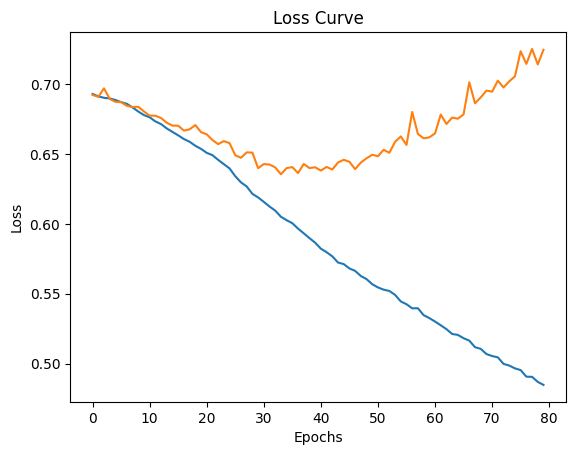

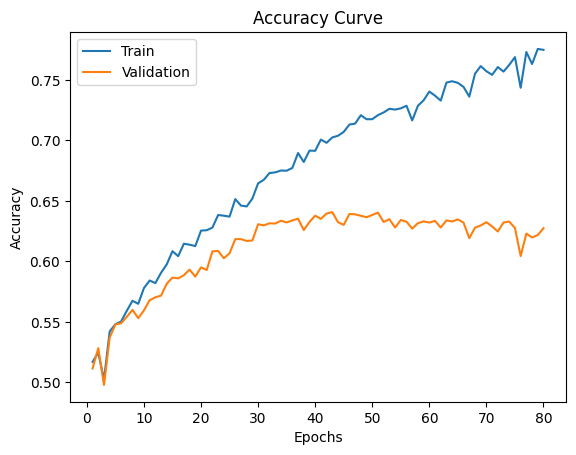

Final Training Accuracy: 0.7748666666666667
Final Validation Accuracy: 0.6274


In [ ]:
model = SentimentRNN(input_shape=(500, 1), num_classes=2, dim_hidden=30,
                     dropout_rate=0, network_type="LSTM").to(device)
train_lstm_network(model, train_loader, val_loader, 80, learning_rate=1e-3)

### Part (iii)

Choose at least 4 hyperparameters to tune.

I tuned 4 hyperparameters: batch size, the way I pool RNN output, learning rate and model(replace LSTM with GRU).

The hyperparameters we choose to tune:
1. utilization of LSTM output: we replace the original "max over length" with "mean and max over length"
2. encoding layer: we replace the original LSTM with GRU of the same parameters
3. dropout structure: we enables the dropout in the LSTM/GRU layouts with drop rate 0.2
4. batch size: we increase the batch size to 64 to make faster convergence
5. hidden size: we increase the hidden size of LSTM/GRU layers to 50 to enable more complex models
6. number of layers in LSTM/GRU block: we increase the number of layers to 3 to enable more complex models

***1. batch size***

In [ ]:
I increased batch size to make faster convergence since from the previous part,
training accuracy is still increasing.
The final validation accuracy was 0.6264, which is lower than the one in
part ii.

In [ ]:
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

Epoch1: Train loss:0.6932006845596248, Val loss:0.6921645088698536, Train acc:0.5178666666666667, Val acc:0.5151
Epoch2: Train loss:0.6915544411902235, Val loss:0.6918696839207659, Train acc:0.5247666666666667, Val acc:0.5301
Epoch3: Train loss:0.6907595286110063, Val loss:0.6900546884003539, Train acc:0.5364, Val acc:0.5322
Epoch4: Train loss:0.6896158764357252, Val loss:0.6903683931682818, Train acc:0.5332666666666667, Val acc:0.5298
Epoch5: Train loss:0.6882346094544254, Val loss:0.6863698264280447, Train acc:0.5501, Val acc:0.551
Epoch6: Train loss:0.6850211230803654, Val loss:0.6860078834116269, Train acc:0.5579, Val acc:0.5477
Epoch7: Train loss:0.6814884882110522, Val loss:0.6853050429600115, Train acc:0.5578, Val acc:0.5491
Epoch8: Train loss:0.6792122427461498, Val loss:0.6805201180445881, Train acc:0.5749666666666666, Val acc:0.5655
Epoch9: Train loss:0.6758985595027013, Val loss:0.68920418553459, Train acc:0.5632666666666667, Val acc:0.5416
Epoch10: Train loss:0.673857727157

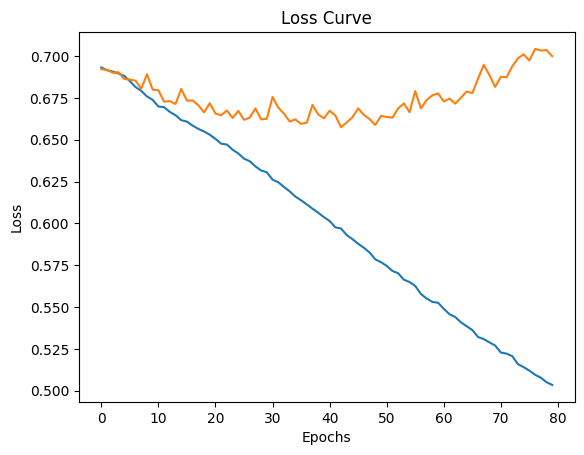

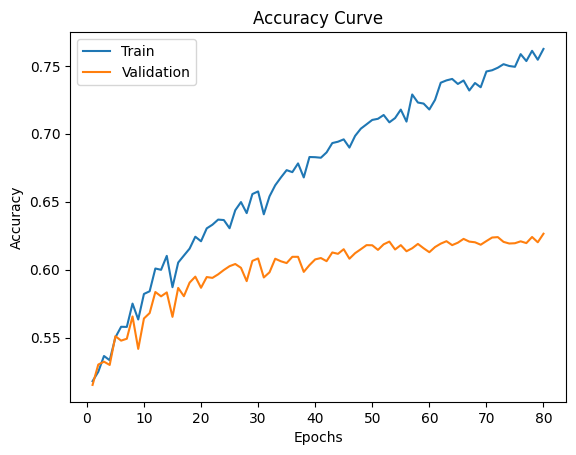

Final Training Accuracy: 0.7624333333333333
Final Validation Accuracy: 0.6264


In [ ]:
model1 = SentimentRNN(input_shape=(500, 1), num_classes=2, dim_hidden=30,
                     dropout_rate=0, network_type="LSTM").to(device)
train_lstm_network(model1, train_loader, val_loader, 80, learning_rate=1e-3)

***2. the way I pool RNN output***

I replaced the original "max over length" with "mean and max over length" since
in part 2 it is stated that this is also one hyperparameter and it is a better
alternative.
The final validation accuracy was 0.6423, which is higher than validaiton
accuracy of model1 and the one in part ii.

In [ ]:
class NewSentimentRNN(nn.Module):
    def __init__(self, input_shape=(500, 1), num_classes=2, dim_hidden=20,
                 dropout_rate=0, network_type="LSTM"):
        """
        Inputs:
        - input shape: (length_of_sequence, num_channels) / (T, C))
        - num_classes: number of classes of targets.
        - dim_hidden: number of hidden features.
        - dropout_rate: rate of fropout before the output linear layer.
        - network_type: the type of sequential layer that we use in this
        network, one of {"LSTM", "GRU"}
        """
        super(NewSentimentRNN, self).__init__()

        self.hidden_size = dim_hidden
        encoders = []
        if network_type == "LSTM":
            encoders.append(nn.LSTM(input_size=input_shape[1],
                                    hidden_size=self.hidden_size,
                                    num_layers=2,
                                    batch_first=True,
                                    dropout=dropout_rate))
        else:
            encoders.append(nn.GRU(input_size=input_shape[1],
                                   hidden_size=self.hidden_size,
                                   num_layers=2,
                                   batch_first=True,
                                   dropout=dropout_rate))
        self.encoder_layers = nn.Sequential(*encoders)

        self.fc = nn.Linear(2 * self.hidden_size, num_classes)


    def forward(self, x):
        out, _ = self.encoder_layers(x)
        # combine the max and mean features along the length channel
        out = torch.cat([torch.max(out, dim=1)[0],
                         #output (N,2*T,hidden_size)
                         torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

Epoch1: Train loss:0.6933646939277649, Val loss:0.6945685647964478, Train acc:0.5030333333333333, Val acc:0.4993
Epoch2: Train loss:0.6926909746805827, Val loss:0.6917528806686402, Train acc:0.5273333333333333, Val acc:0.5269
Epoch3: Train loss:0.6919118955294291, Val loss:0.6914490517616272, Train acc:0.5217, Val acc:0.5258
Epoch4: Train loss:0.6909353496551514, Val loss:0.692329262638092, Train acc:0.5241666666666667, Val acc:0.5242
Epoch5: Train loss:0.690103142897288, Val loss:0.689165745639801, Train acc:0.5386, Val acc:0.538
Epoch6: Train loss:0.6895960220019023, Val loss:0.6895053330421448, Train acc:0.5375, Val acc:0.5352
Epoch7: Train loss:0.6880855609575908, Val loss:0.6870675407409668, Train acc:0.5479333333333334, Val acc:0.5423
Epoch8: Train loss:0.6850872123718261, Val loss:0.6875547625541687, Train acc:0.5487333333333333, Val acc:0.5449
Epoch9: Train loss:0.682093934249878, Val loss:0.6829340543746948, Train acc:0.5689, Val acc:0.5582
Epoch10: Train loss:0.68002043425242

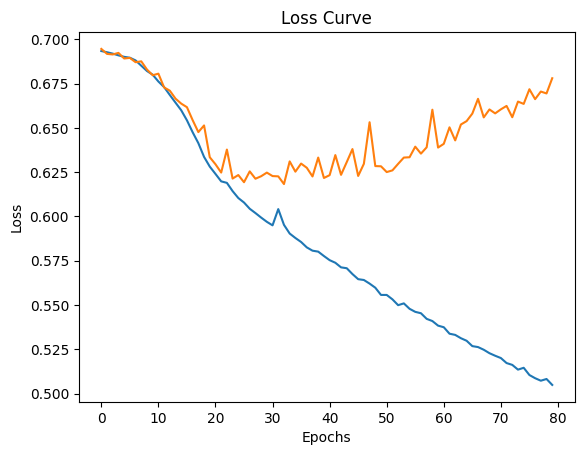

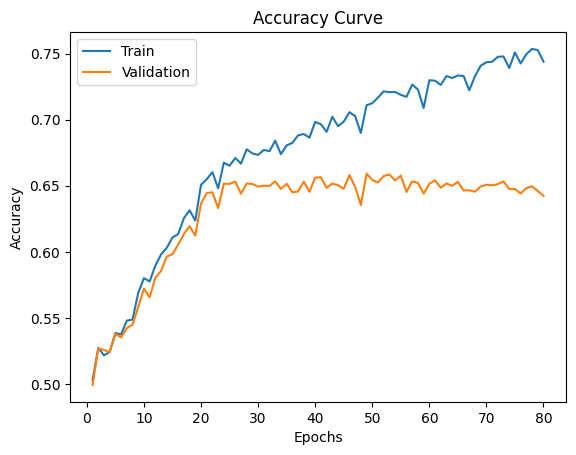

Final Training Accuracy: 0.7438666666666667
Final Validation Accuracy: 0.6423


In [ ]:
model2 = NewSentimentRNN(input_shape=(500, 1), num_classes=2, dim_hidden=30,
                     dropout_rate=0, network_type="LSTM").to(device)
train_lstm_network(model2, train_loader, val_loader, 80, learning_rate=1e-3)

***3. drop out rate***

I added drop out rate to prevent overfitting because in the previous result,
there is a gap between training accuracy and validation accuracy and validation
loss is increasing after epoch 50.
The final validation accuracy was 0.6352, which is lower than validation
accuracy of model2 but there is no overfitting.

Epoch1: Train loss:0.6931453391393025, Val loss:0.692555096912384, Train acc:0.5054333333333333, Val acc:0.5038
Epoch2: Train loss:0.6919433624585469, Val loss:0.6911183577537536, Train acc:0.5276666666666666, Val acc:0.5379
Epoch3: Train loss:0.6912505777359009, Val loss:0.6958107921600342, Train acc:0.5022666666666666, Val acc:0.498
Epoch4: Train loss:0.6906040294329325, Val loss:0.6901654823303223, Train acc:0.5318, Val acc:0.5373
Epoch5: Train loss:0.6900730254809062, Val loss:0.6904343063354492, Train acc:0.5352333333333333, Val acc:0.5325
Epoch6: Train loss:0.6891410416603089, Val loss:0.6880893985748291, Train acc:0.5430666666666667, Val acc:0.5455
Epoch7: Train loss:0.6876097266515097, Val loss:0.6867937466621399, Train acc:0.5542333333333334, Val acc:0.555
Epoch8: Train loss:0.6862938040097555, Val loss:0.6850882070541382, Train acc:0.5578, Val acc:0.5563
Epoch9: Train loss:0.685685711034139, Val loss:0.684908039855957, Train acc:0.5589666666666666, Val acc:0.556
Epoch10: Trai

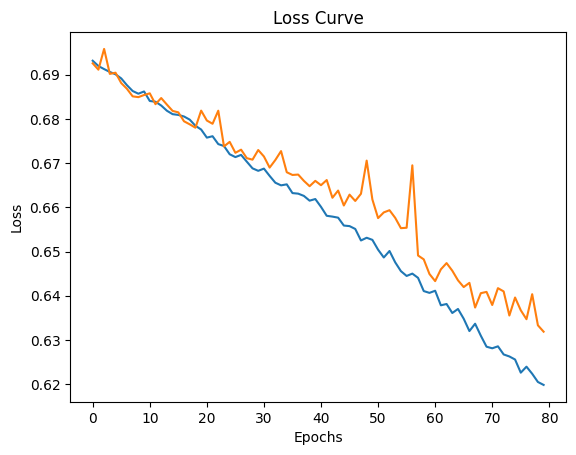

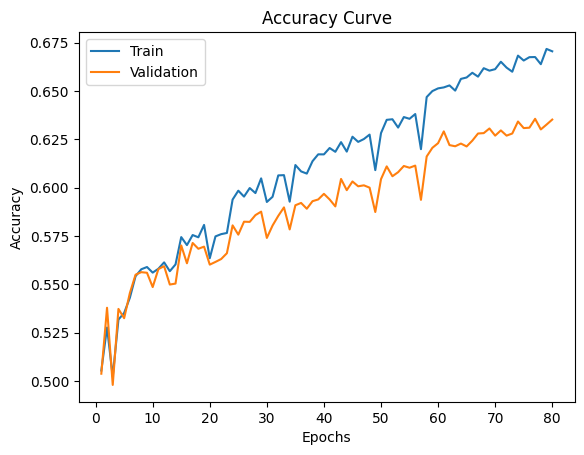

Final Training Accuracy: 0.6705
Final Validation Accuracy: 0.6352


In [ ]:
model3 = NewSentimentRNN(input_shape=(500, 1), num_classes=2, dim_hidden=30,
                     dropout_rate=0.3, network_type="LSTM").to(device)
train_lstm_network(model3, train_loader, val_loader, 80, learning_rate=1e-3)

***4. model***

I change the network type from LSTM to GRU because I want to experiment which
network is better for our problem.
The final validation accuracy was 0.5821, which is lower than model3's.

Epoch1: Train loss:0.6935086454391479, Val loss:0.6932697543144226, Train acc:0.5058333333333334, Val acc:0.502
Epoch2: Train loss:0.691802180703481, Val loss:0.6902162227630615, Train acc:0.5333666666666667, Val acc:0.5427
Epoch3: Train loss:0.6907017378171285, Val loss:0.6896532527923585, Train acc:0.5320333333333334, Val acc:0.5302
Epoch4: Train loss:0.6898468466758728, Val loss:0.6883434282302856, Train acc:0.5366, Val acc:0.5423
Epoch5: Train loss:0.6897323183695475, Val loss:0.687919061088562, Train acc:0.5421666666666667, Val acc:0.5483
Epoch6: Train loss:0.688848261419932, Val loss:0.6874726529121399, Train acc:0.5440333333333334, Val acc:0.5467
Epoch7: Train loss:0.6877723770141602, Val loss:0.6851755060195923, Train acc:0.5528333333333333, Val acc:0.5588
Epoch8: Train loss:0.6858046313285827, Val loss:0.688144068813324, Train acc:0.5447, Val acc:0.5417
Epoch9: Train loss:0.6853078669548035, Val loss:0.682605883693695, Train acc:0.5632, Val acc:0.5636
Epoch10: Train loss:0.683

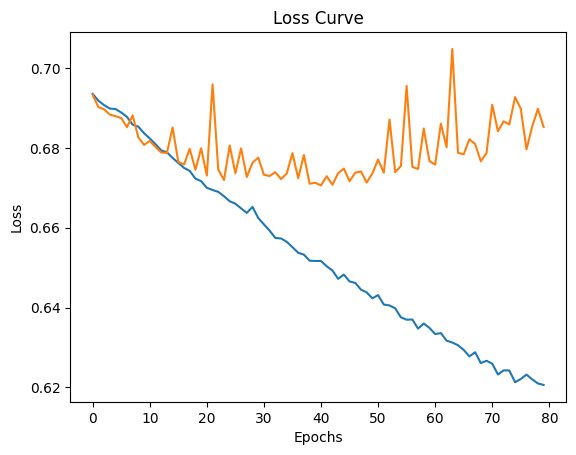

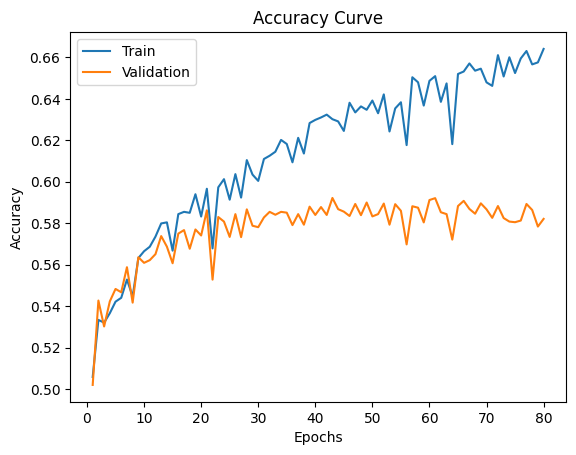

Final Training Accuracy: 0.6641
Final Validation Accuracy: 0.5821


In [ ]:
model4 = NewSentimentRNN(input_shape=(500, 1), num_classes=2, dim_hidden=30,
                     dropout_rate=0.3, network_type="GRU").to(device)
train_lstm_network(model4, train_loader, val_loader, 80, learning_rate=1e-3)

My best model is model2 since it has the highest validation accuracy(64.23%).
model2 runs 80 epoch with learning_rate 1e-3 and I replaced the original "max
over length" with "mean and max over length" for the way I pooled RNN output.

In [ ]:
# Load my best model
best_model = NewSentimentRNN(input_shape=(500, 1), num_classes=2, dim_hidden=30,
                     dropout_rate=0, network_type="LSTM").to(device)
best_model.load_state_dict(torch.load('model79_2.pth'))

<All keys matched successfully>

## Part 4. Evaluation

### Part (i)


In [ ]:
print("The test accuracy of my best model is {}%".format(get_accuracy(best_model, test_loader)*100))

The test accuracy of my best model is 63.72%


The test accuracy of my best model is 63.72%, which is lower than training
accuracy of 74.39% and validation accuracy of 64.23%. But this is as expected
because test data is unseen data. The test accuracy is only slightly lower than
validation accuracy because model's hyperparameters are tuned on validation set.

### Part (ii)

I look over the misclassified samples in the test data and try to find patterns on where the model has difficulty with identifying the review sentiment. I provide up to 5 examples of positive and negative reviews each to support my findings.

In [ ]:
# preprocess test set
stoi_test = get_stoi(X_test)
X_test_token, y_test_token = tokenize(X_test, y_test, stoi_test)
X_test_token = padding_(X_test_token, 500)
X_test_token = torch.FloatTensor(X_test_token).to(device)
y_test_token = torch.FloatTensor(y_test_token).to(device)

<built-in method get of Counter object at 0x7964b4c0d490>


<ipython-input-56-689f26062728>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)


In [ ]:
# find all misclassified examples
mis_pos = []
mis_neg = []

for i in range(len(X_test_token)):
  pred = best_model(torch.unsqueeze(X_test_token[i:i+1], dim=2))
  prob = nn.Softmax()(pred)
  #select index with maximum prediction score
  pred = prob.max(1, keepdim=True)[1]
  result = pred.eq(y_test_token[i:i+1].view_as(pred))
  if not result.item():  # misclassified
    if y_test_token[i:i+1].item() == 0: # should be negative review
      mis_neg.append(i)
    else: # should be positive review
      mis_pos.append(i)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


***Positive review but misclassified***

In [ ]:
print(y_test[mis_pos[0]], "review")
X_test[mis_pos[0]]

positive review


"CRY FREEDOM is an excellent primer for those wanting an overview of apartheid's cruelty in just a couple of hours. Famed director Richard Attenborough (GANDHI) is certainly no stranger to the genre, and the collaboration of the real-life Mr. and Mrs. Woods, the main white characters in their book and in this film, lends further authenticity to CRY FREEDOM. The video now in release actually runs a little over 2 and a half hours since 23 minutes of extra footage was inserted to make it a two part TV miniseries after the film's initial theatrical release. While the added length serves to heighten the film's forgivable flaws: uneven character development and blanket stereotyping in particular, another possible flaw (the insistence on the white characters' fate over that of the African ones) may work out as a strength. Viewing CRYING FREEDOM as a politically and historically educational film (as I think it should, over its artistic merits), the story is one which black Africans know only t

In [ ]:
print(y_test[mis_pos[1]], "review")
X_test[mis_pos[1]]

positive review


'Watching the preview of Armored I thought the movie was either going to be a very bad or a very good film. Thankfully, the movie was entertaining, suspenseful, and realistic. There never is the perfect crime, and Armored showed why. The movie show perfectly when people get into stressful situation they behave like animals. The last hour of the film is very entertaining. Matt Dillon is still a very good actor. Hard to believe Dillon is 50 years of age. I would buy this movie. I give Armored eight out of ten. Not a Christmas movie. Did I write ten lines yet? Nope! Anyways, there is not to many action films. Armored has a lot of excitement in it, which gives the movie goer a choice over another comedy.'

In [ ]:
print(y_test[mis_pos[2]], "review")
X_test[mis_pos[2]]

positive review


'This was Eddie Robinson\'s 101st film and his last, and he died of cancer nine days after shooting was complete. All of which makes his key scene in the movie all the more poignant.<br /><br />Although some of the hair and clothing styles are a bit dated (also note the video game shown in the film), but the subject of the film is pretty much timeless. Heston said he had wanted to make the film for some time because he really believed in the dangers of overpopulation.<br /><br />Several things make this film a classic. The story is solid.<br /><br />The acting is top-notch, especially the interplay between Heston and Robinson, with nice performances also by Cotten and Peters.<br /><br />The music is absolutely perfect. The medley of Beethoven, Grieg, and Tchaikovsky combined with the pastoral visual elements make for some truly moving scenes. This was the icing on the cake for the film.<br /><br />And the theme (or the "point") of the film is a significant one. Yes, it\'s a film about 

In [ ]:
print(y_test[mis_pos[3]], "review")
X_test[mis_pos[3]]

positive review


'The "Hunting Trilogy" of Rabbit Fire (1951), Rabbit Seasoning (1952), and Duck! Rabbit! Duck! (1953) should be considered the comedic high water mark of the Chuck Jones-Michael Maltese collaboration. While they are seldom mentioned in lists of the "greatest" or "most important" cartoons in the history of animation, they are certainly THE FUNNIEST cartoons I\'ve ever seen. Michael Maltese never got the credit that directors like Jones, Freleng or Avery got, but it\'s his dialogue and situations that make Warner Bros. cartoons, and these three in particular, some of the FUNNIEST ever made.'

In [ ]:
print(y_test[mis_pos[4]], "review")
X_test[mis_pos[4]]

positive review


"<br /><br /> I suppose this is not the best film ever made but I voted it at 10 stars all the same. Mainly because of my feelings at the end. I and all the people around me were simply touched. This is something you don't often feel . We are all getting a bit cynical and fed up with over sentimentality, lazy manipulation or preaching in modern films. The story of the film centres around Jane a young woman in the last stages of MND and the friendship that grows between her and Richard, a man on the verge of a breakdown. This could have so easily been a dull and worthy piece but it is so humorous, humane and lacking in sentimentality that it wins you over completely and against the odds is a feel good movie. <br /><br />The acting from Branagh and Bonham-Carter is superb especially the latter who is always believable and strong in her role. The chemistry between the two also lifts the movie. <br /><br />The title comes from Richards masterpiece, a plane made of junk and his old painting

***Negative review but misclassified***

In [ ]:
print(y_test[mis_neg[0]], "review")
X_test[mis_neg[0]]

negative review


'I am quite a fan of novelist/screenwriter Michael Chabon. His novel "Wonder Boys" became a fantastic movie by Curtis Hanson. His masterful novel "The Amazing Adventures of Kavalier and Clay" won the Pulitzer Prize a few years back, and he had a hand in the script of "Spider Man 2", arguably the greatest comic book movie of all time.<br /><br />Director Rawson Marshall Thurber has also directed wonderful comedic pieces, such as the gut-busting "Dodgeball" and the genius short film series "Terry Tate: Office Linebacker". And with a cast including Peter Saarsgard, Sienna Miller, Nick Nolte and Mena Suvari, this seems like a no-brainer.<br /><br />It is. Literally.<br /><br />Jon Foster stars as Art Bechstein, the son of a mobster (Nolte) who recently graduated with a degree in Economics. Jon is in a state of arrested development: he works a minimum wage job at Book Barn, has a vapid relationship with his girlfriend/boss, Phlox (Suvari), which amounts to little more than copious amounts o

In [ ]:
print(y_test[mis_neg[1]], "review")
X_test[mis_neg[1]]

negative review


'Are we talking about the same movie? This movie is totally ridiculous, the plot is disgusting and completely without logic. Its a typical straight to DVD/TV-movie including all the necessary ingredients for a horrible movie experience: Over-acting by has been actors, side steps from the plot that are left unexplained, THE GIRL SHOWS HER T*ts(why, god, why??), people do not react to things as they would in real life. I\'m not even gonna bother you with details, it would take all night. Well, OK, just one: If two people were murdered in front of you as you were walking down the street, one of the victims practically dies in your arms, his blood spurts from his head-wound all over you, would your first concern be; "Oh, he left the world and the last thing he saw was my angry face!"? My thoughts goes to Harvey and his lost career.'

In [ ]:
print(y_test[mis_neg[2]], "review")
X_test[mis_neg[2]]

negative review


"SPOILER - This film gives away plot points and discusses the ending. I hated this film - mostly for political reasons, but also for moral and aesthetic reasons. Politically, this film glorified war and military technology - blowing things up real good. We are led to cheer as the music swells and the Afghans use our weapons to blow the Ruskies to bits. And no U.S. soldiers put their lives on the line - so it's a fun war. Aesthetically, there isn't a touch of real human emotion in the film, just smug, privileged people being sarcastic, feeling superior, and doing whatever they want regardless of the consequences. And speaking of consequences, the film only makes a few small hits at what the arming of the Afghans actually led to. I had read an earlier draft of this script, and it ended on 9/11 - with Charlie Wilson realizing that things had gone horribly wrong. But that wouldn't leave the audience feeling good. This is a feel good movie about killing Ruskies. And it made me sick."

In [ ]:
print(y_test[mis_neg[3]], "review")
X_test[mis_neg[3]]

negative review


"The VHS cover for The Evil Below makes it look like a cool underwater horror flick. Sadly it's closer to a boring adventure flick and has no real horror elements. It starts off with some divers who get attacked and we see a bit of blood, but that's the only blood in the entire film.<br /><br />The Evil Below isn't the worst around, but for a horror film it is tediously boring. The acting is decent and to be honest the only thing that keeps you watching is the developing romance between the two leads. There's a few nightmare sequences where it just seems like the director didn't know what to do. I manged to sit through it all (just about) but I wouldn't recommend this film to ANYONE. Horror fans might want a copy for the cool VHS cover, but it's best left at that."

In [ ]:
print(y_test[mis_neg[4]], "review")
X_test[mis_neg[4]]

negative review


"The plot is straightforward an old man living off a main road in woodland one day witnesses a man murdering a child in the woods. Soft For Digging follows the old man's attempts to try and convince the police that what he saw was not a figment of his imagination. However, there is a problem each time the old man guides the police to where the murder happen no corpse can be found. Soft For Digging has a diminutive dialogue which reflects the majority of the scenes of the film, an old man living by himself in a house. During the film I found that I was scared twice namely when the murdered child abruptly appears before the old man. The rest of the film I have to admit did not engage me; I found the tempo of the film a little too slow. The limited dialogue was not a problem. However, the development of the story and its conclusions, after watching the film, took too long. I feel more could have been made of the relationship, ghostly encounters, with the child and the old man. Alone in th

In the above 5 misclassified positive reviews, people gave both compliment and
critic of the movie and at the end, people still thought it is a good movie
(example 0 and 2). Or people may say things like "this is not the best", but
they still admit it is a good movie(example 3,4). My model had difficulty in
classifying these reviews because these reviews are not purely about how good
the movie is; instead, they point out things can be improved or still think the
movie is good although not the best.

In the above 5 misclassified negative reviews, some people gave both pros and
cons of the movie but the majority part and conclusion was negative review
(example 0, 3, 4) In the rest of review, it was all about critic but people use
words like "good", "ok" (example 1, 2). My model had difficulty in classifying
these reviews because these words themselves are positive, but in the context
they become sarcasm, for example in example 1 "Well, OK". My model cannot detect
these nuances.

### Part (iii)

What is your model's prediction of the **probability** that
the review message provided below is a positive review?


In [ ]:
review = """ Man.... I wish I loved this movie more than I did. Don't get me wrong,
it's a solid action movie with jaw-dropping stunts (some of the best in the series),
but as a Mission: Impossible movie, it felt like a small step backward for the franchise.
Fallout had mind-blowing action sequences and stunt work, along with developing Ethan's
relationship with Ilsa, providing closure with Julia, showing the lengths Ethan would
go to protect those closest to him, and battling an imposing villain. Dead Reckoning:
Part One stretches the movie across two films only to seemingly showcase action
spectacle after action spectacle while sacrificing character development.
Characters I have grown to love over a decade of films felt sidelined, ignored,
or wasted. Hayley Atwell's new character chewed up most of the screen time, and
while she was fantastic, I wanted to see more of the original team. The new villain
had an inconsistent ability that confused more than intimidated. There were some
important emotional moments that I just didn't feel the weight of when I definitely
should have. Part Two might tie everything together and make me enjoy Part One
more in retrospect, but unfortunately, I left wanting more from this one. """

In [ ]:
temp_X = df['review'].values
new_review, _ = tokenize([review], [0], get_stoi(temp_X))
new_review = padding_(new_review, 500)

<built-in method get of Counter object at 0x7c3181a19850>


In [ ]:
pred = best_model(torch.unsqueeze(torch.FloatTensor(new_review).to(device), dim=2))
nn.Softmax()(pred)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.7100, 0.2900]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

The probability that this is a positive review is 29.00%

# PART B - Transfer Learning

For many natural language processing tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to enormous compute requirements and lack of sufficient amounts of training data. Instead, you should always try to take advantage of an existing model that performs similar tasks as the one you need to solve.

In this part of the project, I will be using pretrained models to improve the performance on identifying positive and negative reviews. There are several pretrained models that are available to us, here we will use a pretrained BERT model that comes with the hugging face transformer library.


In [ ]:
# install relevant libraries
!pip install -qq transformers

In [ ]:
# load relevant libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
sample_txt = 'I want to learn how to do sentiment analysis using BERT and tokenizer.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation = True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
encoding['input_ids']

tensor([[  101,   146,  1328,  1106,  3858,  1293,  1106,  1202, 17024,  3622,
          1606,   139,  9637,  1942,  1105, 22559, 17260,   119,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [ ]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
hidden_states = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[0]
pooled_output = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[1]

In [ ]:
hidden_size = bert_model.config.hidden_size

print(hidden_size)
print(hidden_states.shape)
print(pooled_output.shape)


768
torch.Size([1, 32, 768])
torch.Size([1, 768])


In the sample code provided we loaded a short text sequence, tokenized it using the same tokenization that was used in the pretrained BERT model, and fed the tokenized input into the BERT model to obtain the embeddings.

The model output consists of two forms of embeddings:
- **hidden_states** are the final layer of outputs that has a shape sequence_length x embeddings, much like the hidden states of a recurrent neural network
- **pooled_output** is the result of applying max pooling on the hidden states to effectively collapse the sequence dimenension and ensure the same output size for any given sequence before feeding into the classification stage

Note that you can preprocess all of the data prior to training a classifier stage for sentiment analysis to help speed up the training process. This is no different from the process we applied in an earlier assignment using AlexNet and image data.

## Part 1. Data Loading

I will be using the same "IMDB Movie Review Dataset" that I used earlier.

### Part (i)

Run the DataLoader to create training, validation, and test data.

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MovieReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    #target = self.targets[item]
    target = 1 if self.targets[item] == 'positive' else 0

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #pad_to_max_length=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# load dataset
df = pd.read_csv("IMDB Dataset.csv")

# process into data and labels
X = df['review'].values
y = df['sentiment'].values

# split dataset
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
X_val , X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

# training set
df_train = pd.DataFrame({'review': X_train, 'sentiment': y_train})
# validation set
df_val = pd.DataFrame({'review': X_val, 'sentiment': y_val})
# test set
df_test = pd.DataFrame({'review': X_test, 'sentiment': y_test})

In [ ]:
# prepare data loaders
MAX_LEN = 400
BATCH_SIZE = 8

#training data
train_data = MovieReviewDataset(reviews=df_train['review'].to_numpy(),
                                targets=df_train['sentiment'].to_numpy(),
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)

train_data_loader = DataLoader(train_data, batch_size = BATCH_SIZE,
                               num_workers = 4) #modify num_works as needed

#validation data

val_data = MovieReviewDataset(reviews=df_val['review'].to_numpy(),
                              targets=df_val['sentiment'].to_numpy(),
                              tokenizer=tokenizer,
                              max_len=MAX_LEN)

val_data_loader = DataLoader(val_data, batch_size = BATCH_SIZE, num_workers = 4)

#test data

test_data = MovieReviewDataset(reviews=df_test['review'].to_numpy(),
                               targets=df_test['sentiment'].to_numpy(),
                               tokenizer=tokenizer,
                               max_len=MAX_LEN)

test_data_loader = DataLoader(test_data, batch_size = BATCH_SIZE,
                              num_workers = 4)

### Part (ii)

Use the **train_data_loader** to load one sample. What are the different attributes provided with the sample and how are they used?

In [ ]:
sample = next(iter(train_data_loader))
sample

{'review_text': ["This has to be one of the worst films I have ever seen.<br /><br />We are supposed to like and be rooting for an arrogant, know-it-all, trashy bank robber, played by Dale Robertson, and a coy tease played by the extra-ordinarily beautiful Linda Darnell in a fire engine red dress. She must have been sewed into that bodice! <br /><br />A Senator in the film thinks Native Americans and whites should try to come to an understanding, the bigots, however, win the day. I could barely sit through the endless dialog of bigotry that issued from the other characters mouths.<br /><br />Except for Wounded Knee and Dances with Wolves there are few films that give a positive portrayal of American Indians, and very few old westerns do. This one is exceptionally bad in that regard.<br /><br />The romance between Robertson and Darnell set my teeth on edge, as he came swaggering in, forcing a kiss on her, while she plays the old hard to get game.<br /><br />There are scenes that are uni

There are 4 attributes provided with the sample:review_text,input_ids,
attention_mask, and targets.
review_text stores the raw text reviews that need to be tokenized before and
converted into numerical representation before feeding into BERT.
input_ids and attention_mask are fed into the BERT model to get the embeddings.
targets is the true labels which are used in training and evaluating BERT.

### Part (iii)

Determine the range of values for the tokens in the training data.

In [ ]:
min_id = float('inf')
non_zero_min_id = float('inf')
max_id = float('-inf')

for review in train_data_loader:
  input_ids = review['input_ids']
  non_zero_ids = input_ids[input_ids != 0] #remove 0 in tensor
  # token id
  non_zero_min_id = min(non_zero_min_id, torch.min(non_zero_ids).item())
  min_id = min(min_id, torch.min(input_ids).item())
  max_id = max(max_id, torch.max(input_ids).item())

# actual token
non_zero_token = tokenizer.convert_ids_to_tokens(non_zero_min_id)
min_id_token = tokenizer.convert_ids_to_tokens(min_id)
max_id_token = tokenizer.convert_ids_to_tokens(max_id)

print("Min non-zero token id:{}, corresponding token:{}".
      format(non_zero_min_id, non_zero_token))
print("Min token id:{}, corresponding token:{}".format(min_id, min_id_token))
print("Max token id:{}, corresponding token:{}".format(max_id, max_id_token))

Min non-zero token id:100, corresponding token:[UNK]
Min token id:0, corresponding token:[PAD]
Max token id:28466, corresponding token:##ר


The minimum token id is 0 and it refers to padding, the minimum non-zero token
id is 100 and it refers to UNK, and the maximum token id is 28466 and it refers
to ##ר.
In "bert-base-cased", review are tokenized into tokens first and then convert
into token_id to input into the model. So in the tokenizer's vocabulary, each
token_id corresponds to a unique token.

### Part (iv)

Generate histograms of all the token values in the training data. Repeat for the validation and test data.

In [ ]:
# training
token_list = []
for review in train_data_loader:
  input_ids = review['input_ids']
  input_ids = torch.flatten(input_ids)
  for id in input_ids:
    id_key = id.item()
    token_list.append(id_key)

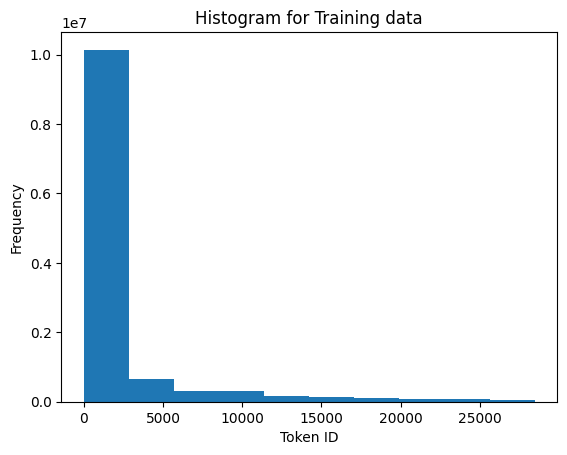

In [ ]:
plt.hist(token_list)
plt.xlabel('Token ID')
plt.ylabel('Frequency')
plt.title('Histogram for Training data')
plt.show()

In [ ]:
from collections import Counter

# top 5 token id & corresponding token
counter = Counter(token_list)
top_ids = counter.most_common(5)
for id, frequency in top_ids:
    token = tokenizer.convert_ids_to_tokens(id)
    print("id {}: {} times; represent {}".format(id, frequency, token))

id 0: 4266480 times; represent [PAD]
id 119: 319841 times; represent .
id 1103: 277398 times; represent the
id 117: 259788 times; represent ,
id 170: 154588 times; represent a


In [ ]:
# validation
token_list_val = []
for review in val_data_loader:
  input_ids = review['input_ids']
  input_ids = torch.flatten(input_ids)
  for id in input_ids:
    id_key = id.item()
    token_list_val.append(id_key)

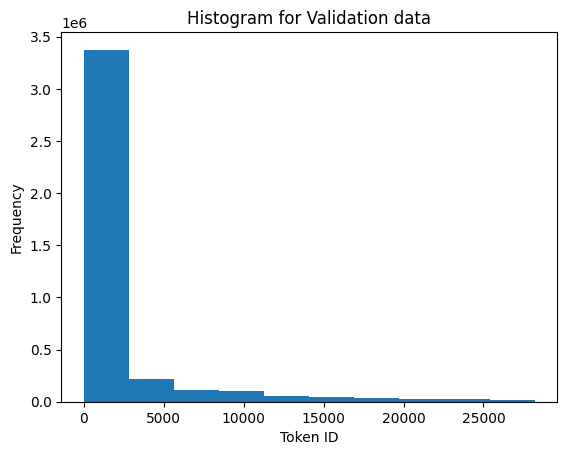

In [ ]:
plt.hist(token_list_val)
plt.xlabel('Token ID')
plt.ylabel('Frequency')
plt.title('Histogram for Validation data')
plt.show()

In [ ]:
# test
token_list_test = []
for review in test_data_loader:
  input_ids = review['input_ids']
  input_ids = torch.flatten(input_ids)
  for id in input_ids:
    id_key = id.item()
    token_list_test.append(id_key)

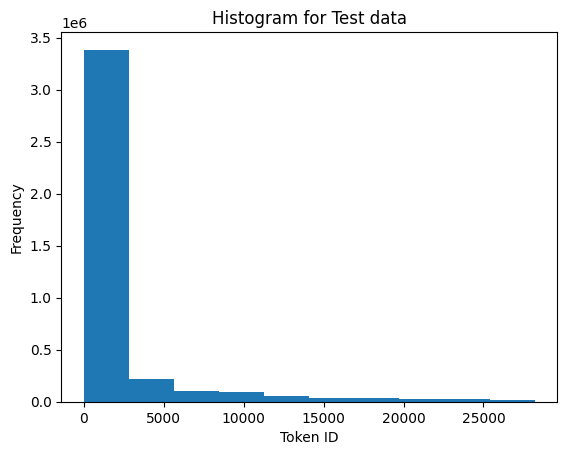

In [ ]:
plt.hist(token_list_test)
plt.xlabel('Token ID')
plt.ylabel('Frequency')
plt.title('Histogram for Test data')
plt.show()

The top 5 occuring tokens in training set are token id 0, 119 1103, 117, 170.
They represent 'PAD', '.', 'the', ',' and 'a' respectively.

### Part (v)

Select a single sample from my training DataLoader and feed it through the **bert_model** to obtain the hidden_states and pooled_output. Briefly describe what each tensor dimension represents and what affects the size of each dimension.

In [ ]:
sample = next(iter(train_data_loader))
sample_txt = sample['review_text'][0] #select one review
sample_txt

"This has to be one of the worst films I have ever seen.<br /><br />We are supposed to like and be rooting for an arrogant, know-it-all, trashy bank robber, played by Dale Robertson, and a coy tease played by the extra-ordinarily beautiful Linda Darnell in a fire engine red dress. She must have been sewed into that bodice! <br /><br />A Senator in the film thinks Native Americans and whites should try to come to an understanding, the bigots, however, win the day. I could barely sit through the endless dialog of bigotry that issued from the other characters mouths.<br /><br />Except for Wounded Knee and Dances with Wolves there are few films that give a positive portrayal of American Indians, and very few old westerns do. This one is exceptionally bad in that regard.<br /><br />The romance between Robertson and Darnell set my teeth on edge, as he came swaggering in, forcing a kiss on her, while she plays the old hard to get game.<br /><br />There are scenes that are unintentionally humo

In [ ]:
# encode
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=400,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation = True
)

# feed to BERT
hidden_states = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[0]
pooled_output = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[1]
# dimension
print(hidden_states.shape)
print(pooled_output.shape)

torch.Size([1, 400, 768])
torch.Size([1, 768])


For hidden state, it has a 3-dimensional tensor.
The first number(1) represents batch size, in this case we have one because I
only selected one review. If batch size increases, the first number will
increase.
The second number(400) represents sequence length. If the max_length defined in
tokenizer.encode_plus increases, the second number will increase.
The third number(768) represents hidden size/embedding size. It defines the
dimensionality of hidden states and it is a hyperparameter that can be set in
training.

For pooled output, it has 2-dimensional tensor.
The first number(1) represents batch size because I selected only one review.
The number of input samples affects this number.
The second number(768) represents hidden size. It defines the
dimensionality of hidden states and it is a hyperparameter that can be set in
training.

## Part 2. Model Architecture

### Part (i)

Prepare a review classifier model that builds on the pooled output from the Bert model to identify positive and negative reviews.

In [ ]:
class SentimentClassifierPooled(nn.Module):

  def __init__(self, n_classes=2):
    super(SentimentClassifierPooled, self).__init__()
    self.bert = bert_model

    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(768, n_classes)

  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(input_ids=input_ids,
                              attention_mask=attention_mask)[1]

    output = self.drop(pooled_output)
    output = self.out(output)
    return output

### Part (ii)

Construct the architecture for a review classifier model that uses the last hidden output from the Bert model to identify positive and negative reviews.

In [ ]:
class SentimentClassifierLast(nn.Module):

  def __init__(self, n_classes=2):
    super(SentimentClassifierLast, self).__init__()
    self.bert = bert_model

    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(768, n_classes)

  def forward(self, input_ids, attention_mask):

    output = self.bert(input_ids=input_ids,
                              attention_mask=attention_mask)
    # extract the representation of the [CLS] token (the first token)
    cls_representation = output.last_hidden_state[:, 0, :]
    #cls_representation = output.last_hidden_state.mean(dim=1)
    cls_representation = self.drop(cls_representation)
    output = self.out(cls_representation)
    return output

## Part 3. Training

### Part (i)

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [ ]:
def get_accuracy_bert(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid_loader) # the variable `valid_loader` is from
    above
    """

    model.eval() # evaluation mode
    correct = 0
    total = 0

    for batch in data:
      input_ids = batch['input_ids']
      attention_mask = batch['attention_mask']
      targets = batch['targets']

      #############################################
      #To Enable GPU Usage
      if torch.cuda.is_available():
        input_ids = input_ids.cuda()
        attention_mask = attention_mask.cuda()
        targets = targets.cuda()
      #############################################

      output = model(input_ids, attention_mask)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(targets.view_as(pred)).sum().item()
      total += targets.size(0)

    accuracy = correct / total
    return accuracy

### Part (ii)

Write a function **train_model** to train my model. Plot the training curve of your final model.

In [ ]:
def get_val_loss_bert(model, valid_loader):
    total_loss = 0.0
    i = 0
    model.eval() # evaluation mode
    for batch in valid_loader:
      input_ids = batch['input_ids']
      attention_mask = batch['attention_mask']
      targets = batch['targets']

      #############################################
      #To Enable GPU Usage
      if torch.cuda.is_available():
        input_ids = input_ids.cuda()
        attention_mask = attention_mask.cuda()
        targets = targets.cuda()
      #############################################

      pred = model(input_ids, attention_mask)
      loss = nn.CrossEntropyLoss()(pred, targets)
      total_loss += loss.item()
      i += 1
    return float(total_loss)/i

In [ ]:
def train_bert(model, train_loader, valid_loader, num_epoch=5,
               learning_rate=1e-5):
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  epochs, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

  for epoch in range(num_epoch):
    model.train()
    total_train_loss = 0.0
    i = 0

    for batch in train_loader:
      targets = batch['targets']
      ids = batch['input_ids']
      mask = batch['attention_mask']
      #############################################
      #To Enable GPU Usage
      if torch.cuda.is_available():
        targets = targets.cuda()
        ids = ids.cuda()
        mask = mask.cuda()
      #############################################
      optimizer.zero_grad()
      pred = model(ids, mask)
      loss = nn.CrossEntropyLoss()(pred, targets)
      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()
      i += 1

    # for plotting
    epochs.append(epoch)
    model.eval()
    train_loss.append(float(total_train_loss)/i)
    val_loss.append(get_val_loss_bert(model, valid_loader))
    train_acc.append(get_accuracy_bert(model, train_loader))
    val_acc.append(get_accuracy_bert(model, valid_loader))

    print("Epoch{}: Train loss:{}, Val loss:{}, Train acc:{}, Val acc:{}".
          format(epoch+1,train_loss[-1],val_loss[-1],train_acc[-1],val_acc[-1]))

    #save model
    torch.save(model.state_dict(), 'bert_model{}.pth'.format(epoch))

  # plotting
  plt.title("Loss Curve")
  plt.plot(epochs, train_loss, label="Train")
  plt.plot(epochs, val_loss, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Accuracy Curve")
  plt.plot(range(1, num_epoch+1), train_acc, label="Train")
  plt.plot(range(1, num_epoch+1), val_acc, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
Epoch1: Train loss:0.027281162598946442, Val loss:0.42168046318925917, Train acc:0.9993333333333333, Val acc:0.914
Epoch2: Train loss:0.012490835630412525, Val loss:0.40589192913565786, Train acc:0.998, Val acc:0.902
Epoch3: Train loss:0.01351125960261561, Val loss:0.3361700868078042, Train acc:0.9996666666666667, Val acc:0.922
Epoch4: Train loss:0.003520190684784514, Val loss:0.41699470656376797, Train acc:1.0, Val acc:0.924
Epoch5: Train loss:0.0031642182511277496, Val loss:0.5485633808212588, Train acc:1.0, Val acc:0.911


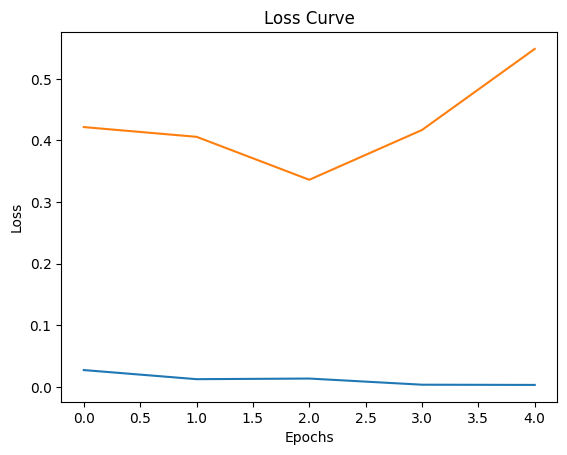

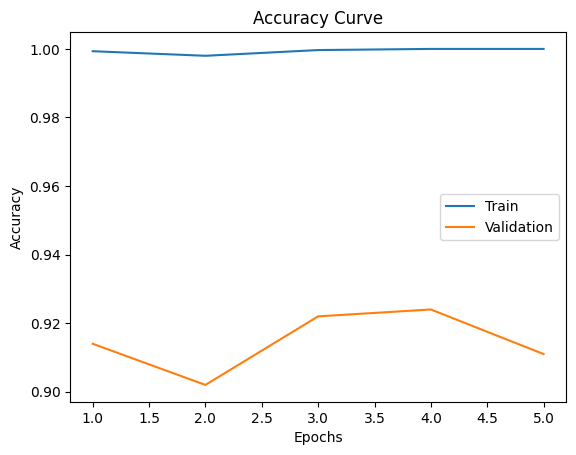

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.911


In [ ]:
# use SentimentClassifierLast
model_last = SentimentClassifierLast(2)

use_cuda = True
if use_cuda and torch.cuda.is_available():
  model_last.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_bert(model_last, train_data_loader, val_data_loader, 5, 1e-5)

CUDA is available!  Training on GPU ...
Epoch1: Train loss:0.21574215659995874, Val loss:0.27528219002112747, Train acc:0.96, Val acc:0.886
Epoch2: Train loss:0.10561623210584124, Val loss:0.3602889969646931, Train acc:0.972, Val acc:0.888
Epoch3: Train loss:0.06965186722762882, Val loss:0.24500988360121848, Train acc:0.9933333333333333, Val acc:0.918
Epoch4: Train loss:0.04446953792342295, Val loss:0.3271278737159446, Train acc:0.996, Val acc:0.903
Epoch5: Train loss:0.03234250377987822, Val loss:0.3467741860859096, Train acc:0.998, Val acc:0.909


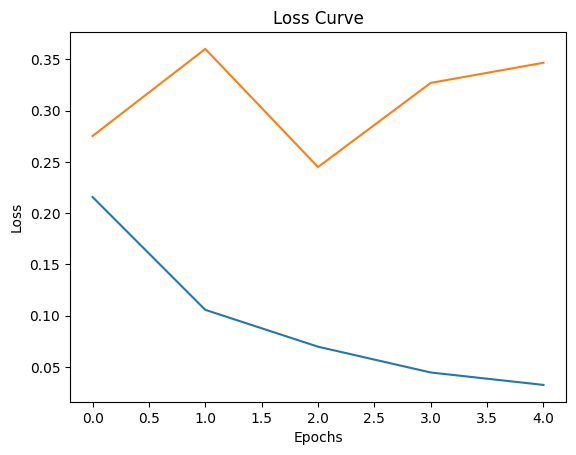

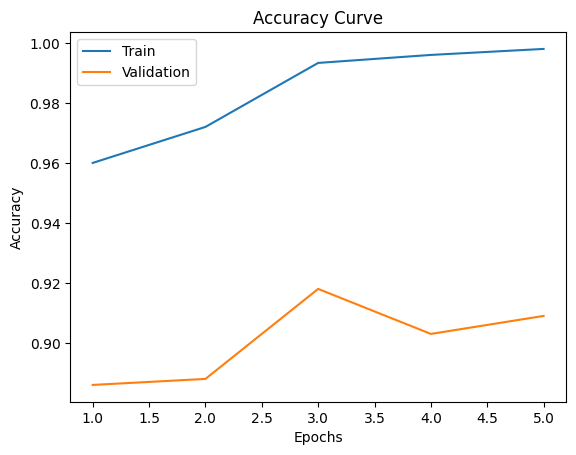

Final Training Accuracy: 0.998
Final Validation Accuracy: 0.909


In [ ]:
# use SentimentClassifierPooled
model_pooled = SentimentClassifierPooled(2)

use_cuda = True
if use_cuda and torch.cuda.is_available():
  model_pooled.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_bert(model_pooled, train_data_loader, val_data_loader, 5, 1e-5)

### Part (iii)

Choose at least 4 hyperparameters to tune.

I tuned 4 hyperparameters: dropout rate, learning rate, number of epoch and model structure.

***SentimentClassifierLast classifier***

***1. model structure***

I changed from using cls to using mean in the classifier for experiment to see
if this way helps extract more useful information.
The final validation accuracy was 0.894, which is lower than the one in part ii.
So I switched back to using cls instead.

In [ ]:
class NewSentimentClassifierLast(nn.Module):

  def __init__(self, n_classes=2):
    super(NewSentimentClassifierLast, self).__init__()
    self.bert = bert_model

    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(768, n_classes)

  def forward(self, input_ids, attention_mask):

    output = self.bert(input_ids=input_ids,
                              attention_mask=attention_mask)
    # extract the mean representation
    cls_representation = output.last_hidden_state.mean(dim=1)
    cls_representation = self.drop(cls_representation)
    output = self.out(cls_representation)
    return output

CUDA is available!  Training on GPU ...
Epoch1: Train loss:0.04453764808705697, Val loss:0.32077237073890863, Train acc:0.9973333333333333, Val acc:0.91
Epoch2: Train loss:0.02289095742177839, Val loss:0.33888608891656624, Train acc:0.9983333333333333, Val acc:0.921
Epoch3: Train loss:0.024692258259203907, Val loss:0.3648553205109201, Train acc:0.998, Val acc:0.907
Epoch4: Train loss:0.02113115243924161, Val loss:0.4053696839548647, Train acc:0.999, Val acc:0.909
Epoch5: Train loss:0.017756001532621062, Val loss:0.48016463640658186, Train acc:0.998, Val acc:0.894


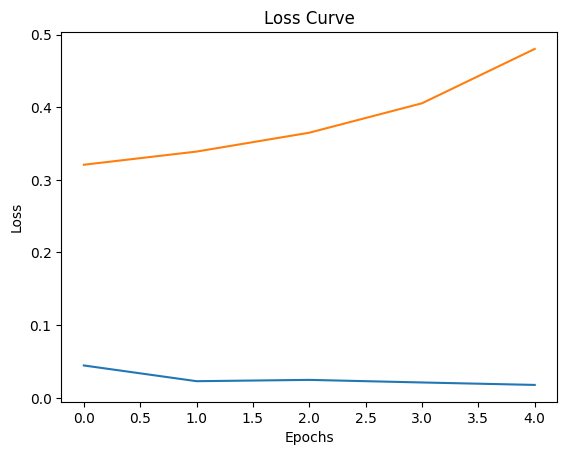

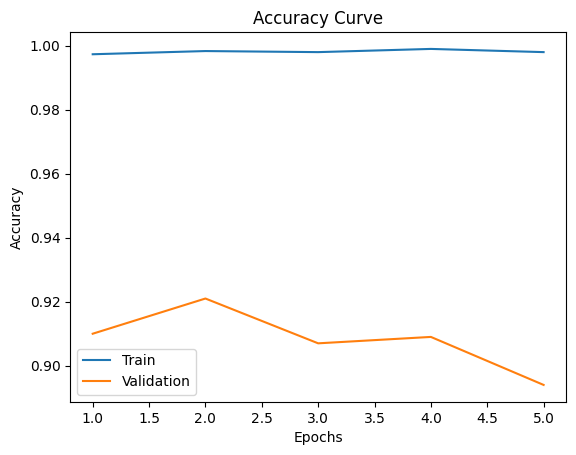

Final Training Accuracy: 0.998
Final Validation Accuracy: 0.894


In [ ]:
model1 = NewSentimentClassifierLast(2)

use_cuda = True
if use_cuda and torch.cuda.is_available():
  model1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_bert(model1, train_data_loader, val_data_loader, 5, 1e-5)

***2. number of epoch***

I decreased number of epoch because the model already performs well on epoch 1
and validation accuracy is decreasing in part ii.
The final validation accuracy is 0.903, which is lower than the one in part ii.

CUDA is available!  Training on GPU ...
Epoch1: Train loss:0.030382205004803837, Val loss:0.4095260049253702, Train acc:0.9986666666666667, Val acc:0.903
Epoch2: Train loss:0.009835126871320729, Val loss:0.5497495545812416, Train acc:0.9986666666666667, Val acc:0.903
Epoch3: Train loss:0.005036648580300001, Val loss:0.5301914371186868, Train acc:0.9996666666666667, Val acc:0.903


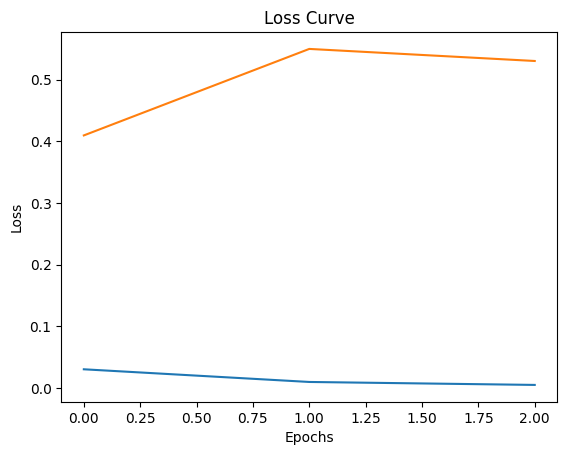

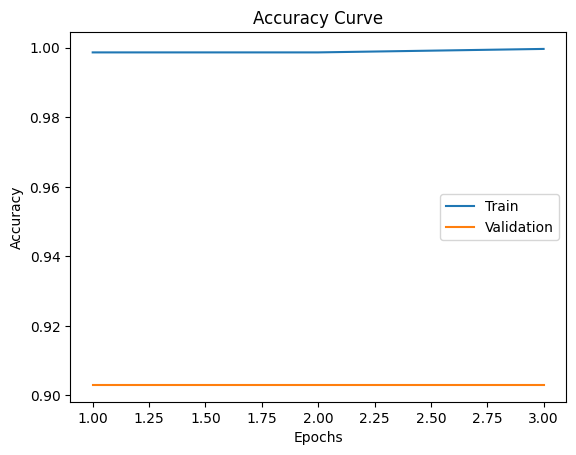

Final Training Accuracy: 0.9996666666666667
Final Validation Accuracy: 0.903


In [ ]:
model2 = SentimentClassifierLast(2)

use_cuda = True
if use_cuda and torch.cuda.is_available():
  model2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_bert(model2, train_data_loader, val_data_loader, 3, 1e-5)

***SentimentClassifierPooled classifier***

***3. dropout rate***

I increased the dropout rate since in part ii, training accuracy is almost 100%.
I want to have a more robust model although validation accuracy has not started
decreasing.
The final validation accuracy is 0.914, which is higher than the one in part ii.

In [ ]:
class NewSentimentClassifierPooled(nn.Module):

  def __init__(self, n_classes=2):
    super(NewSentimentClassifierPooled, self).__init__()
    self.bert = bert_model

    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(768, n_classes)

  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(input_ids=input_ids,
                              attention_mask=attention_mask)[1]

    output = self.drop(pooled_output)
    output = self.out(output)
    return output

CUDA is available!  Training on GPU ...
Epoch1: Train loss:0.025817965630441905, Val loss:0.525637643492315, Train acc:0.9996666666666667, Val acc:0.893
Epoch2: Train loss:0.009066341548226773, Val loss:0.5003612514559646, Train acc:0.9996666666666667, Val acc:0.9
Epoch3: Train loss:0.01823304878664203, Val loss:0.3652365794037469, Train acc:1.0, Val acc:0.921
Epoch4: Train loss:0.0037480649831704797, Val loss:0.4187076751586283, Train acc:1.0, Val acc:0.921
Epoch5: Train loss:0.0025046358310695117, Val loss:0.46612986995326355, Train acc:1.0, Val acc:0.914


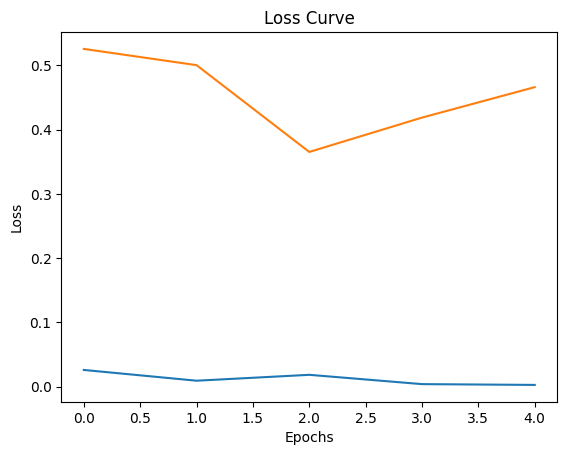

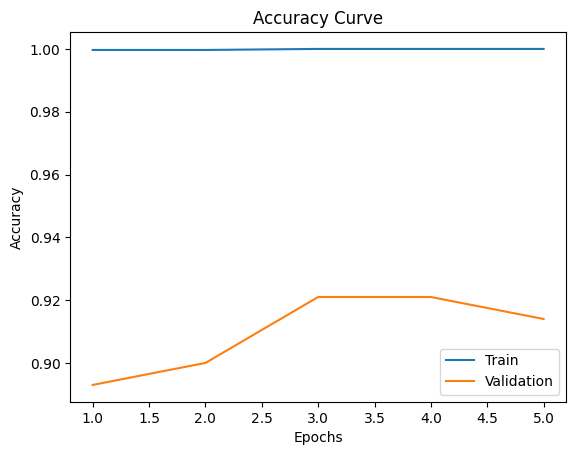

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.914


In [ ]:
model3 = NewSentimentClassifierPooled(2)

use_cuda = True
if use_cuda and torch.cuda.is_available():
  model3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_bert(model3, train_data_loader, val_data_loader, 5, 1e-5)

***4. learning rate***

I decreased learning rate because the model is already close to convergence and
I want to fine tune to reach a more precise solution.
The final validation accuracy is 0.917, which is higher than the one in part ii
and model3.

CUDA is available!  Training on GPU ...
Epoch1: Train loss:0.12476108986139298, Val loss:0.24177744852006436, Train acc:1.0, Val acc:0.919
Epoch2: Train loss:0.024815658492346605, Val loss:0.2757886734008789, Train acc:1.0, Val acc:0.918
Epoch3: Train loss:0.011643409545222918, Val loss:0.3218533568419516, Train acc:1.0, Val acc:0.912
Epoch4: Train loss:0.006393639070913196, Val loss:0.3246661690510809, Train acc:1.0, Val acc:0.917
Epoch5: Train loss:0.0038767441858847938, Val loss:0.3444431722937152, Train acc:1.0, Val acc:0.917


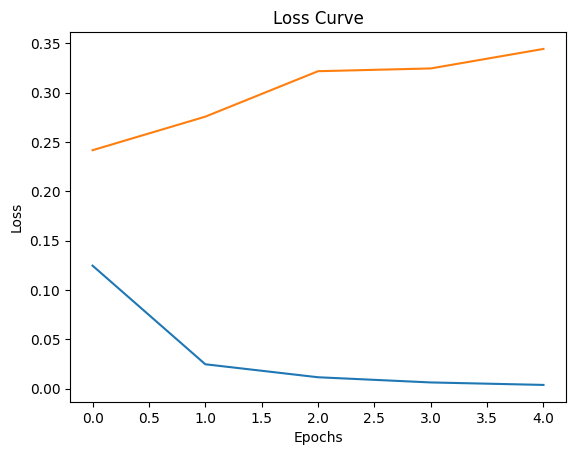

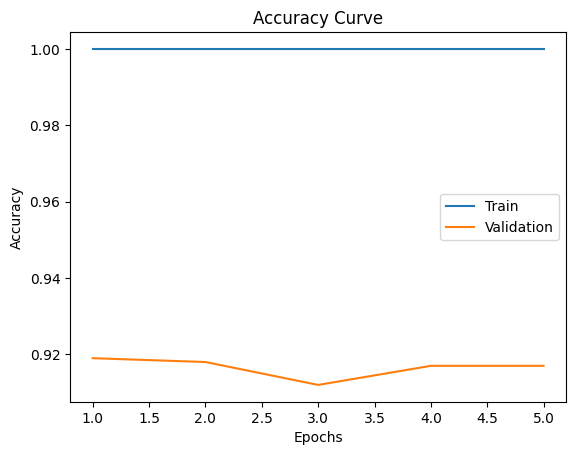

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.917


In [ ]:
model4 = NewSentimentClassifierPooled(2)

use_cuda = True
if use_cuda and torch.cuda.is_available():
  model4.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_bert(model4, train_data_loader, val_data_loader, 5, 1e-6)

My best model is model4 with highest validation accuracy of 0.917. It uses
NewSentimentClassifierPooled as classifier, it runs 5 epoch with learning rate =
1e-6.

In [ ]:
# Load my best model
best_model_bert = NewSentimentClassifierPooled(2).cuda()
best_model_bert.load_state_dict(torch.load('bert_model4.pth'))

<All keys matched successfully>

## Part 4. Evaluation

### Part (i)

Report the final test accuracy of my best BERT-based model. Then summarize in a pandas dataframe the accuracy obtained on the training, validation, and test data of my best models from Part A and B.



In [ ]:
print("The test accuracy of my best model is {}%".format(
    get_accuracy_bert(best_model_bert, test_data_loader)*100))

The test accuracy of my best model is 90.81%


In [ ]:
# summarize in pandas dataframe
accuracy_results = {'training accuracy(%)': [74.39, 100.0],
        'validation accuracy(%)': [64.23, 91.1],
        'test accuracy(%)': [63.72, 90.81]}

df_results = pd.DataFrame(accuracy_results, index=['Part A', 'Part B'])
df_results

,training accuracy(%),validation accuracy(%),test accuracy(%)
Part A,74.39,64.23,63.72
Part B,100.00,91.10,90.81


The final test accuracy of my best BERT-based model is 90.81%.
The BERT model performed much better than my model in part A by 27.09% higher in
test accuracy, 27.47% higher in validation accuracy and 25.61% higher in
training accuracy.

This is as expected because BERT model is pre-trained on a large corpus of text
data and it has learned to capture rich semantic information. So the word
embeddings it generate is context-aware. In comparison, my best model from
Part A only trained on 30000 data set and there are still many area to improve
on this model. So BERT model should have higher accuracy than LSTM model.

### Part (ii)

Report the false positive rate and false negative rate of my model across the test set. Then summarize in a pandas dataframe the false postive and false negative rate of my model obtained on the training, validation, and test data of your best models from Part A and B.


In [ ]:
# create a test set with only positive reviews(positive is label 1)
df_fp = df_test[df_test['sentiment'] == 'positive']

# data loader for part A:
stoi_test_fp = get_stoi(df_fp['review'])
X_fp, y_fp = tokenize(df_fp['review'], df_fp['sentiment'],
                                      stoi_test_fp)
X_fp = padding_(X_fp, 500)
X_fp = torch.FloatTensor(X_fp).to(device)
y_fp = torch.FloatTensor(y_fp).to(device)
fp_dataset = ReviewData(X_fp, y_fp)
BATCH_SIZE = 16
fp_loader = torch.utils.data.DataLoader(fp_dataset, BATCH_SIZE, shuffle=True)

# data loader for part B:
test_data_fp = MovieReviewDataset(reviews=df_fp['review'].to_numpy(),
                               targets=df_fp['sentiment'].to_numpy(),
                               tokenizer=tokenizer,
                               max_len=MAX_LEN)

BATCH_SIZE = 8
test_data_loader_fp = DataLoader(test_data_fp, batch_size = BATCH_SIZE,
                                 num_workers = 4)

# false positive rate
fp_a = 1-get_accuracy(best_model, fp_loader)
fp_b = 1-get_accuracy_bert(best_model_bert, test_data_loader_fp)
print("The false positive rate of my part A best model is {}%".format(
    fp_a*100))
print("The false positive rate of my part B best model is {}%".format(
    fp_b*100))

<built-in method get of Counter object at 0x79636c56ede0>


<ipython-input-56-689f26062728>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)


The false positive rate of my part A best model is 55.562261114463894%
The false positive rate of my part B best model is 9.716354858177434%


In [ ]:
# create a test set with only negative reviews(negative is label 0)
df_fn = df_test[df_test['sentiment'] == 'negative']

# data loader for part A:
stoi_test_fn = get_stoi(df_fn['review'])
X_fn, y_fn = tokenize(df_fn['review'], df_fn['sentiment'],
                                      stoi_test_fn)
X_fn = padding_(X_fn, 500)
X_fn = torch.FloatTensor(X_fn).to(device)
y_fn = torch.FloatTensor(y_fn).to(device)
fn_dataset = ReviewData(X_fn, y_fn)
BATCH_SIZE = 16
fn_loader = torch.utils.data.DataLoader(fn_dataset, BATCH_SIZE, shuffle=True)

# data loader for part B:
test_data_fn = MovieReviewDataset(reviews=df_fn['review'].to_numpy(),
                               targets=df_fn['sentiment'].to_numpy(),
                               tokenizer=tokenizer,
                               max_len=MAX_LEN)
BATCH_SIZE = 8
test_data_loader_fn = DataLoader(test_data_fn, batch_size = BATCH_SIZE,
                                 num_workers = 4)

# false negative rate
fn_a = 1-get_accuracy(best_model, fn_loader)
fn_b = 1-get_accuracy_bert(best_model_bert, test_data_loader_fn)
print("The false negative rate of my part A best model is {}%".format(
    fn_a*100))
print("The false negative rate of my part B best model is {}%".format(
    fn_b*100))

<built-in method get of Counter object at 0x7ee709cd26b0>


<ipython-input-15-689f26062728>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)


The false negative rate of my part A best model is 33.44601312388149%
The false negative rate of my part B best model is 10.499105189898582%


In [ ]:
# summarize in pandas dataframe
false_results = {'False Positive': [55.56, 9.72],
        'False Negative': [33.45, 10.50]}

df_false = pd.DataFrame(false_results, index=['Part A', 'Part B'])
df_false

,False Positive,False Negative
Part A,55.56,33.45
Part B,9.72,10.50


BERT model clearly have a lower false positive rate and a lower false negative
rate. This is as expected because BERT model is pre-trained on large corpus, so
it can capture contextual embeddings by considering bidirectional context while
this is not the case in LSTM. So BERT model should have lower both rates.

### Part (iii)
Examine some of the misclassified reviews from my best BERT and LSTM models to better identify the differences in the models. Try to provide some justification for any differences in the misclassifications observed in the models.


In [ ]:
# misclassified reviews from BERT
mis_pos = [] # positive reviews that are misclassified as negative
mis_neg = [] # negative reviews that are misclassified as positive

for batch in test_data_loader:
  targets = batch['targets'].cuda()
  ids = batch['input_ids'].cuda()
  mask = batch['attention_mask'].cuda()
  review = batch['review_text']

  pred = best_model_bert(ids, mask)
  prob = nn.Softmax()(pred)
  pred = prob.max(1, keepdim=True)[1]
  result = pred.eq(targets.view_as(pred))

  if result.sum() != 8: # not a full batch have correct result
    sample_i = 0 # count index
    for sample in result: # find which sample misclassifies
      if not sample.item(): # misclassified
        if targets[sample_i].item() == 0: # should be negative review
          mis_neg.append(review[sample_i])
          sample_i += 1
        else:  # should be positive review
          mis_pos.append(review[sample_i])
          sample_i += 1
      else: # classify correctly
        sample_i += 1

In [ ]:
mis_pos[3]

"Anyone who loves the Rheostatics' music is going to enjoy this film. I have some minor complaints, mainly about pacing and the casting of certain actors (not Maury) who aren't really convincing in their roles, but I don't have time write a detailed review. I just want to warn anyone who has seen this film or plans to watch this film as presented CBC television in Canada: The version that airs are the CBC is like the Reader's Digest version of WHALE MUSIC---don't watch it. It cuts out entire scenes and subplots (if you can them that) from the film. The CBC, which presents most of films untouched, took half the guts out of WHALE MUSIC. I don't know why. It's horrible what they did to the film. Rent the video or watch it in a theatre, but DON'T watch it on CBC television."

In [ ]:
mis_pos[5]

'This is how I interpreted the movie: First things first. There was not a single scene in the movie where u see the bad guy (Taylor) torturing or nailing Ben\'s hands to the wall. However the same cannot be told of the gals. In the end too, u see Taylor disappear as he walks. Looks like the message there was "There was no Taylor". And the whole movie was a figment of imagination of Ben. Also, there was no scene during the torturing moments wherein any of the gals confront or are in the same frame as Ben. It was Taylor all the time. But in real, Taylor was Ben. If they were two different people, then why was there no scene showing both of them in one frame during the horrific times? But of course before that, u do see both of them together and THAT cud just be Ben\'s imagination at work. Also, when Ben was out of jail, the text on screen clearly says that Ben\'s story was unrealistic and there was no such place as he had explained (read mine, cars etc...)Even after Liz Hunter leaves Kri

In [ ]:
mis_neg[3]

"Not a movie, but a lip synched collection of performances from acts that were part of the British Invasion, that followed the dynamic entrance of the Beatles to the music world. Some of these acts did not make a big splash on this side of the pond, but a lot of them did. Featured are: Herman's Hermits, Billy J. Kramer and the Dakotas, Peter and Gordon, Honeycombs, Nashville Teens, Animals, and of course,the Beatles.<br /><br />It is so much fun watching these young acts before they honed and polished their acts."

In [ ]:
mis_neg[10]

'This experimental silent film, made in Switzerland by an independent British film company, is chiefly remembered as Paul Robeson\'s first film. It\'s very artistic, with shots often seeming meaningless to the story, which is difficult to understand anyway because of the lack of enough inter-titles. From what I gathered, Robeson\'s wife, Adah, is in an inter-racial love affair with a white man called Thorne. It doesn\'t bother the cigar-chomping owner of the bar/hotel where Thorne lives (and she seems to be having a lesbian relationship with a barmaid), but an old lady expresses the town\'s point of view in an inter-title: "If I had my way, we wouldn\'t allow negroes in here." Thorne is also called "nigger lover" by someone in the bar. Adah tries a reconciliation with Pete (Robeson), but eventually leaves him. Thorne\'s wife, Astrid, goes off the deep end, brandishes a knife, cuts Thorne\'s arm and cheek, and somehow dies. Thorne must have been accused of murder because we learn he was

From the above misclassified samples from BERT model, it can be seen that the
misclassified positive reviews(should be positive but classified as negative)
contain some complaint or neutral discussion about the movie plot. So the
positive sentiment is either not very strong or the review sentiment contains
both positive and negative, although slightly more positive.
For the misclassified negative reviews, sentiment is also subtle. People spent
a long length to discuss the movie plot and there is a mix of sentiment. For
example, in example 2, the person began with "it is very artistic" which sounds
positive and then continue with "with shots often seeming meaningless to the
story" which is negative.

In conclusion, my BERT model had difficulty classifying reviews that have a mix
of sentiment or sentiment is subtle.

In [ ]:
# some misclassified reviews from LSTM
X_test[mis_neg[1]]

'Are we talking about the same movie? This movie is totally ridiculous, the plot is disgusting and completely without logic. Its a typical straight to DVD/TV-movie including all the necessary ingredients for a horrible movie experience: Over-acting by has been actors, side steps from the plot that are left unexplained, THE GIRL SHOWS HER T*ts(why, god, why??), people do not react to things as they would in real life. I\'m not even gonna bother you with details, it would take all night. Well, OK, just one: If two people were murdered in front of you as you were walking down the street, one of the victims practically dies in your arms, his blood spurts from his head-wound all over you, would your first concern be; "Oh, he left the world and the last thing he saw was my angry face!"? My thoughts goes to Harvey and his lost career.'

Recall from Part A that I found out my LSTM model had difficulty classifying
reviews that either contain sarcasm or has a mix of sentiment.

***Modify review***

In [ ]:
# try modify review for BERT
# changed 'don't watch it' into 'watch another version'
review_mod = '''Anyone who loves the Rheostatics' music is going to enjoy this
film. I have some minor complaints, mainly about pacing and the casting of
certain actors (not Maury) who aren't really convincing in their roles, but I
don't have time write a detailed review. I just want to warn anyone who has seen
this film or plans to watch this film as presented CBC television in Canada: The
version that airs are the CBC is like the Reader's Digest version of WHALE MUSIC
---watch another version. It cuts out entire scenes and subplots (if you can
them that) from the film. The CBC, which presents most of films untouched, took
half the guts out of WHALE MUSIC. I don't know why. It's horrible what they did
to the film. Rent the video or watch it in a theatre, but DON'T use CBC
television.'''

In [ ]:
df_mod = pd.DataFrame({'review': review_mod, 'sentiment': [1]})
mod_data = MovieReviewDataset(reviews=df_mod['review'].to_numpy(),
                                targets=df_mod['sentiment'].to_numpy(),
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)
BATCH_SIZE = 1
mod_loader = DataLoader(mod_data, batch_size = BATCH_SIZE,
                           num_workers = 4)

result_bert = []

for batch in mod_loader:
  input_ids = batch['input_ids'].cuda()
  attention_mask = batch['attention_mask'].cuda()
  targets = batch['targets'].cuda()

  output_bert = best_model_bert(input_ids, attention_mask)
  pred_bert = output_bert.max(1, keepdim=True)[1]
  result_bert.append(pred_bert.eq(targets.view_as(pred_bert)))

result_bert  # True means correctly predict

[tensor([[True]], device='cuda:0')]

I changed 'don't watch it' into 'watch another version' without changing the
original meaning since the person was trying to warn people not to use CBC
television to watch the movie, not warning people not to watch the movie.
This change helps BERT correctly predicts the result, it should be a positive
review and it is classified as positive now.

In [ ]:
# try modify review for LSTM
# delete 'Well, OK'
review_modified = '''Are we talking about the same movie? This movie is totally
ridiculous, the plot is disgusting and completely without logic. Its a typical
straight to DVD/TV-movie including all the necessary ingredients for a horrible
movie experience: Over-acting by has been actors, side steps from the plot that
are left unexplained, THE GIRL SHOWS HER T*ts(why, god, why??), people do not
react to things as they would in real life. I\'m not even gonna bother you with
details, it would take all night. Just one: If two people were murdered in front
of you as you were walking down the street, one of the victims practically dies
in your arms, his blood spurts from his head-wound all over you, would your
first concern be; "Oh, he left the world and the last thing he saw was my angry
face!"? My thoughts goes to Harvey and his lost career.'''

In [ ]:
temp_X = df['review'].values
new_review, _ = tokenize([review_modified], [0], get_stoi(temp_X))
new_review = padding_(new_review, 500)
pred = best_model(torch.unsqueeze(torch.FloatTensor(new_review).to(device),
                                  dim=2))
prob = nn.Softmax()(pred)
prob  # should predict negative; negative is label 0

<built-in method get of Counter object at 0x795f59b5b1f0>


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.8004, 0.1996]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

I deleted the sacarsm part of using 'Well, OK' and the rest is the same. After
modifying, LSTM predicts correctly this time. It should be negative review and
it is now classified as negative.

### Part (iv)
Find 5 samples of positive and negative reviews on IMDB that were posted recently and evaluate them with the best BERT and LSTM models from parts A and B.

In [ ]:
# 5 positive reviews
review1 = '''Having not previously seen the Disney-animated version of Aladdin-
just choice clips usually featuring the Robin Williams-voiced Genie-I do
understand this Disney-live-action version is mostly the same sequence of events
with the same songs with one addition. So on that note, I very much enjoyed this
with my movie theatre-working friend. Will Smith is amusing enough as the Genie
now and when the more dramatic scenes come, I was touched enough by the story,
characters, and the actors playing them. And those songs are, of course, as
awesome as ever! So on that note, I recommend this version of Aladdin.'''

review2 = '''It's honestly absurd how good the "Spider-Verse" movies are.
"Across the Spider-Verse" is just as great, if not better than "Into the
Spider-Verse". I really don't know how. "Spider-Man: Across the Spider-Verse" is
fantastic! Deftly juggles deeply heartfelt character beats with crazy multiverse
content, just packed with so many delightful easter eggs. Loved how Gwen's story
is expanded, her scenes with Shea Whigham's Captain Stacy are truly special.
Can't wait for the third one. Every frame of this movie is gorgeous! I didn't
want to blink because I didn't want to miss anything. You can watch this film
over & over & finds something new to enjoy. There are some surprises in this
film that I truly wasn't expecting. "Across the Spider-Verse" is another
milestone for animation. Yes it's gorgeous & visually mind-blowing, but this
sequel surpasses the first for always putting Miles and his family front and
center. The movie feels like a massive celebration for Spider-Man fans
everywhere, whether you love the movies, games, comics, etc. But again, all the
cameos and multiversal elements come second to both Miles and Gwen's story. Is a
stunning achievement. Yes, it's visually dazzling, with expansive, expressive
new realms The movie's real superpower is its emotional depth and its beautiful,
melancholic tone. What more can I say...It's an actual work of art! Every frame
deserves to be hung in a museum. The jokes and nods to Spidey lore are perfect.
It's outstanding. "Spider-Man: Across the Spider-Verse" is yet another
resounding win for the Lord Miller-produced universe. Hailee Steinfeld really
comes into her own as Gwen Stacy. It's darker and sadder than I expected, but
necessary. '''

review3 = '''Every once in a while a movie comes, that truly makes an impact.
Joaquin's performance and scenography in all it's brilliance. Grotesque,
haunting and cringy. Hard to watch at times,... but so mesmerizing, you won't
blink an eye watching it. Tragic, but with seriously funny moments. Emotional
rollercoaster - sometimes, with multiple emotions popping-up at the same time.
this is far from a typical action-riddled predictable super-hero movie - it's a
proper psychological thriller/drama, with the single best character development
I have ever seen. '''

review4 = '''This is a movie that only those who have felt alone and isolated
can truly relate to it. You understand the motive and you feel sorry for the
character. A lot of people will see this movie and think that it encourages
violence. But truly, this movie should encourage each and every one of us to
become a better person, treat everyone with respect and make each other feel
like they belong in this world, instead of making them feel isolated.'''

review5 = '''This film is a visual concert. The animation and character design
neatly put me to tears. The opening of the film took an approach that shocked
me, but it was fantastic to watch. Many of the jokes were in the trailers, but
plenty caught me off guard in the cinema. Miguel even had a couple of funny
moments. The presence of existing spider characters, such as snippets of the
other films, did feel somewhat strange I have to admit. However, it is made up
for in how incredible this film was. It was artistic, mature, adult, and
profound. It leaves the viewer on a cliffhanger that shocked me. I thought I was
an hour into the film, but it was the end. I implore everyone wondering if they
should see this film to do so. Easily the best film I have seen in a long time
and the best film to see in theaters. A true masterpiece. '''

In [ ]:
# 5 negative reviews
review6 = '''Just lazy storytelling... Wherever you look these days (no matter
Marvel or DC) there just a bunch of unrelated stories that are connected
together by the "Multiverse". I mean come on! We get it, there are endless
possibilities in across infinite universes but why should writers use this just
to compensate for their inability to stick to and finish a story. How is it that
whenever they are faced with challenges of their own making they just skip to
another universe just to get rid of them. I miss the days when Comics were just
about an old school story with complex characters with complex motivations. I
think that alone can identify as a compelling script.'''

review7 = '''I love comic book adaptations. I have watched Cartoons/Animated
Series since I was a child, so for over 40 years. This is the first movie I have
walked out of and asked for a refund in about 20 to 25 years. The animation that
everyone seems to be hyping was spasmodic. It actually hurt to watch. I do not
have epilepsy or any other neurological disorder, but I felt ill and had to
leave or risk making a mess that no one working in the theater gets paid enough
to clean. The plot, in as much as I saw, was pure drivel. Just juvenile
angstness. Maybe teens will like it for that reason. I obviously won't be
watching the next movie.'''

review8 = '''The theme that teenagers know better than their parents has been
done to death. "They don't know me" is also a tired cliche. Lotsa flashes of
color seem pointless other than to get the ADHD generation's attention and to
stretch out the running time. The first half is rather dreary. The second half
is more interesting with more plot twists than an O. Henry anthology, but by
then I'd lost interest and resented that they made me sit through the first
half. The end is a shameless "To Be Continued". You would think the writers
would have followed the multiverse underpinning and came up with something more
original and succinct.'''

review9 = '''I'm a huge marvel fanboy, and hardly ever have anything bad to say
to about the MCU, but this was a huge letdown. Ragnarok is easily one of my top
5 marvel films , so was very excited to see this one, but this was really really
bad. It was boring as hell and none of the jokes landed for me. First time in a
marvel movie I really wanted to leave or wished it would end already. Huge waste
of Gorr the god butcher. And the whole Zeus and Olympus part were so cringe
worthy. I don't know how this got made. It was garbage.'''

review10 = '''String of jokes and gags. Bland fight sequences. Hollow
characters. Candypop colours and bling. Lazy, formulaic BGM. Pointless,
absolutely unnecessary. When did Marvel become a spoof of its own material? Even
The Powerpuff Girls had more sincerity than Love and Thunder. Waited for two
hours to feel SOMETHING. All I felt was a headache and a pair of tired eyes.'''

In [ ]:
review = [review1, review2, review3, review4, review5, review6, review7,
          review8, review9, review10]
label = [1,1,1,1,1,0,0,0,0,0]
label_sentiment = ['positive','positive','positive','positive','positive',
                   'negative','negative','negative','negative','negative']

In [ ]:
# use LSTM
temp_X = df['review'].values
new_review, _ = tokenize(review, label, get_stoi(temp_X))
new_review = padding_(new_review, 500)
pred = best_model(torch.unsqueeze(torch.FloatTensor(new_review).to(device), dim=2))
prob = nn.Softmax()(pred)
pred = prob.max(1, keepdim=True)[1]
result = pred.eq(torch.FloatTensor(label).cuda().view_as(pred))
result

<built-in method get of Counter object at 0x7aaff69dbc40>


<ipython-input-127-689f26062728>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True]], device='cuda:0')

In [ ]:
# use BERT
df_recent = pd.DataFrame({'review': review, 'sentiment': label_sentiment})
recent_data = MovieReviewDataset(reviews=df_recent['review'].to_numpy(),
                                targets=df_recent['sentiment'].to_numpy(),
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)
BATCH_SIZE = 10
recent_loader = DataLoader(recent_data, batch_size = BATCH_SIZE,
                           num_workers = 4)

result_bert = []

for batch in recent_loader:
  input_ids = batch['input_ids'].cuda()
  attention_mask = batch['attention_mask'].cuda()
  targets = batch['targets'].cuda()

  output_bert = best_model_bert(input_ids, attention_mask)
  pred_bert = output_bert.max(1, keepdim=True)[1]
  result_bert.append(pred_bert.eq(targets.view_as(pred_bert)))

result_bert

[tensor([[True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True]], device='cuda:0')]

LSTM performs bad because only 4 out of 10 reviews are classified correctly.
More specifically, it misclassified 4 positive reviews and 2 negative reviews.

BERT model performs very good since all reviews are classified correctly.